In [1]:
import Scribe as sc
from Scribe.Scribe import causal_net_dynamics_coupling as Scribe
import scanpy as sp
import numpy as np 
import os
import networkx as nx 
nx.__version__

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import dynamo as dyn 
import mygene
from anndata import AnnData

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

/home/pipkin/anaconda3/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Running scvelo 0.1.25 (python 3.7.6) on 2020-05-04 22:10.


In [2]:
wkdir = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/3_Scribe'
os.chdir(wkdir)

-----

<h1><font size="8", color="3399ff"><center> 1. scVelo </center></font></h1>

## 1.0 Read velocyto loom file

In [3]:
wkdir = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_2_scVelo'
os.chdir(wkdir)

loom_file = "/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_2_Velocyto/Exp391.loom"
adata = scv.read(loom_file, cache=True)
adata.var_names_make_unique()

# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.68 0.27 0.06]


AnnData object with n_obs × n_vars = 18353 × 22630 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## 1.1 Preliminary filtering & data merging

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
scv.pp.log1p(adata)

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 12269 genes that are detected in less than 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 507 genes that are detected in less than 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
computing neighbors
    finished (0:00:12) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## 1.2 Add Scanpy-PAGA info

In [5]:
#####----- Read scanpy files
sc_obs_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/obs.csv'
sc_obsm_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/obsm.csv'
sc_count_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all_norm_counts_named_c10.csv'

sc_obs_tb = pd.read_csv(sc_obs_file)
sc_obsm_tb = pd.read_csv(sc_obsm_file)
sc_count_tb = pd.read_csv(sc_count_file)

# Merge fa to obs_tb
sc_obs_tb['fa1'] = sc_obsm_tb['X_draw_graph_fa1']
sc_obs_tb['fa2'] = sc_obsm_tb['X_draw_graph_fa2']

# Unifying format of cell id & 
sc_cell_id = list(sc_obs_tb.iloc[:,0])
sc_cell_id = [x.replace("-1", "") for x in sc_cell_id]
sc_obs_tb.columns = ["cell_id"] +  list(sc_obs_tb.columns)[1:] # change column names
sc_obs_tb['cell_id'] = sc_cell_id # Use unified format for Cell ID

sc_gene_name = list(sc_count_tb.columns)[1:]

#####----- Cell filtering and gene filtering based on scanpy analysis
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
scv_gene_name = list(adata.var.index)
scv_cell_use = ["Use" if x in sc_cell_id else "No" for x in scv_cell_id]
adata.obs['scanpy_paga'] = scv_cell_use

adata = adata[adata.obs['scanpy_paga'] == 'Use', :]

#####----- Use same cell id order for obs_tb and vlm object
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
sc_cell_id = list(sc_obs_tb['cell_id'])

sc_cell_id_newidx = [sc_cell_id.index(x) for x in scv_cell_id]
sc_obs_tb = sc_obs_tb.reindex(sc_cell_id_newidx)


#####----- Add FA
sc_fa = pd.DataFrame({'fa1': sc_obs_tb['fa1'], 'fa2': sc_obs_tb['fa2']})
adata.obsm = {'fa': sc_fa.to_numpy()}

#####----- Add obs from scanpy-paga
adata.obs['cell_type'] = list(sc_obs_tb['cell_type'])
adata.obs['louvain'] = list(sc_obs_tb['louvain'])

## 1.3 Run scVelo

In [6]:
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'fa' to convention 'X_fa' (adata.obsm).
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


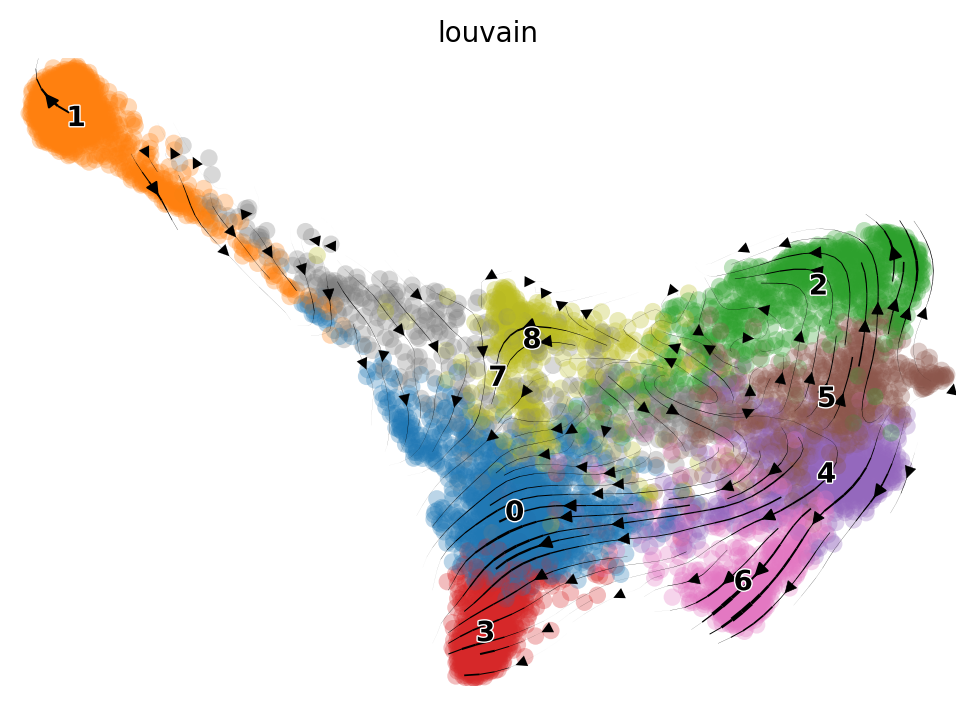

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='fa', color=['louvain'], dpi=100)

<h1><font size="8", color="3399ff"><center> 2. Scribe </center></font></h1>

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


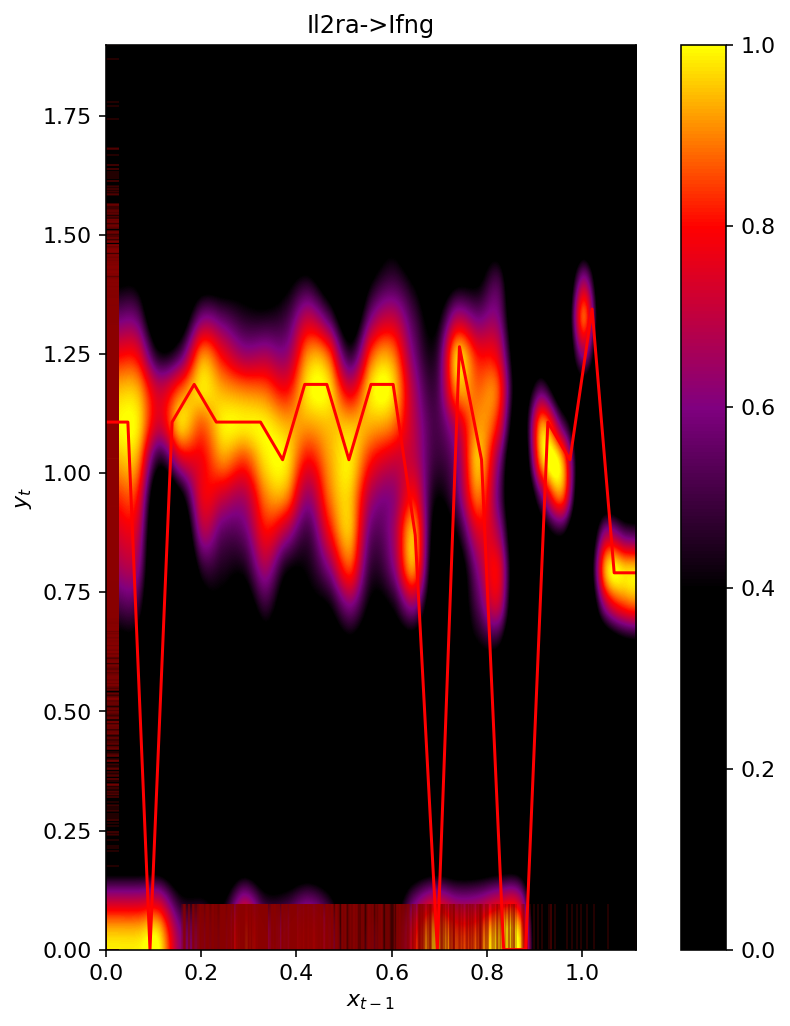

In [8]:
sc.pl.viz_response(adata, np.array([['Il2ra','Ifng']]),grid_num=25, log=True)

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix
f_ini_ind is  0   25


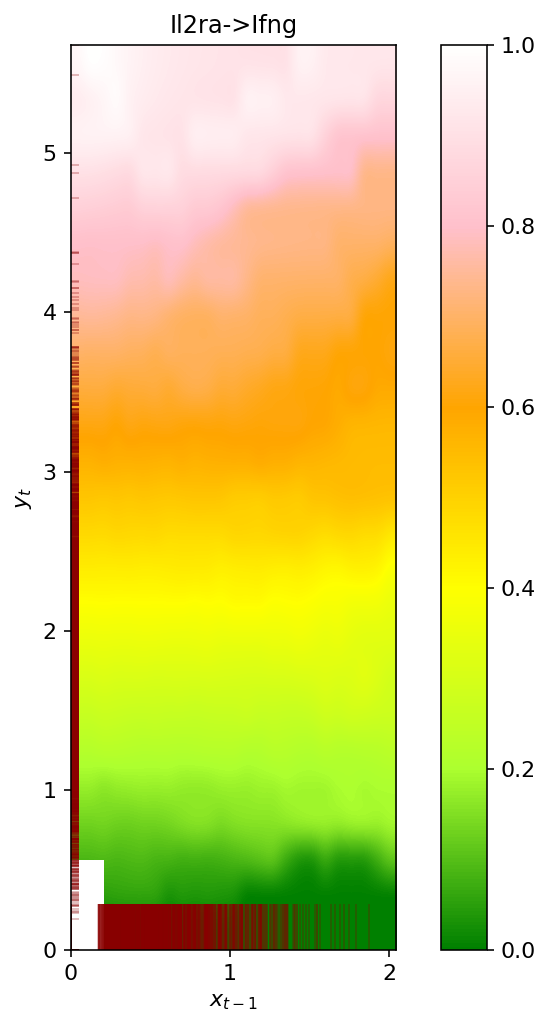

In [9]:
sc.pl.viz_causality(adata,np.array([['Il2ra','Ifng']]),grid_num=25, log=False)

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


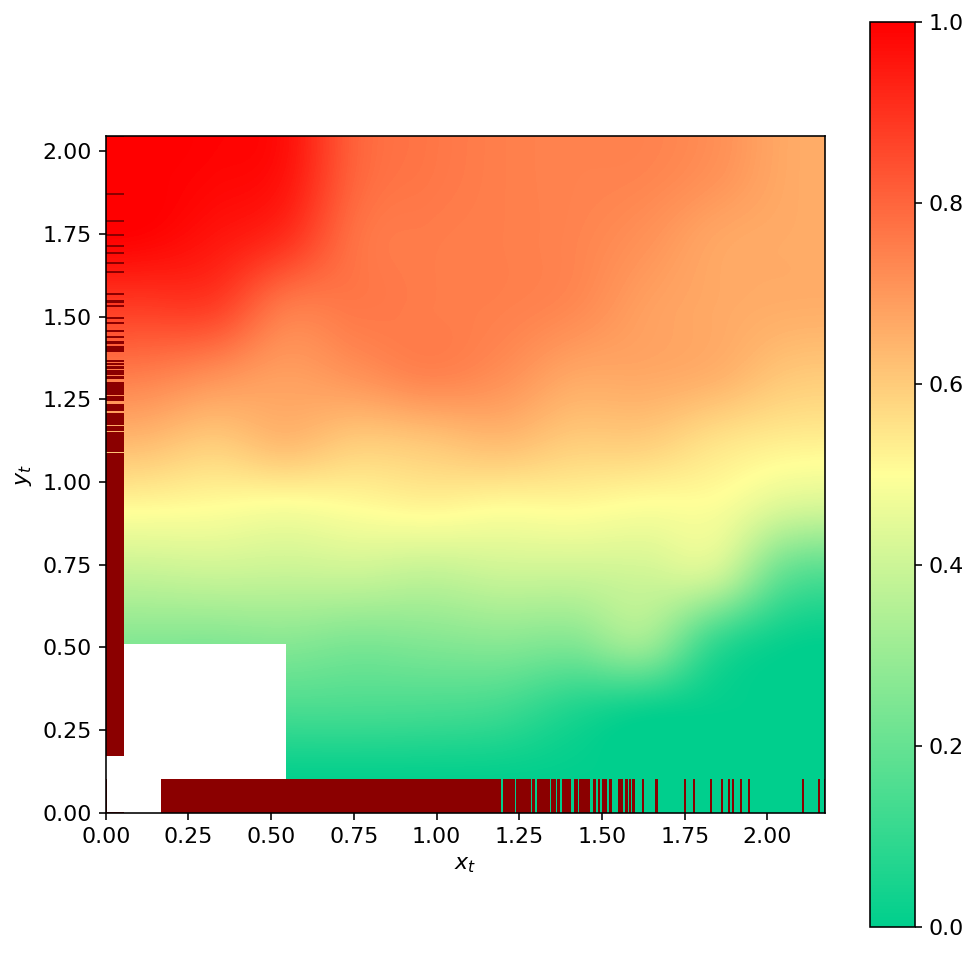

In [10]:
sc.pl.viz_comb_logic(adata,np.array([['Irf4','Il2ra', 'Ifng']]),grid_num=10, log=False)

### Select genes to use

In [ ]:
Scribe(adata, t0_key='spliced', t1_key='unspliced')
adata.uns['causal_net'].to_csv('causal_net_all.csv')